In [362]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by elastic net 

Before a lasso regression was applied, but lead to not profound set of predictors, each model run lead to a nearly complete new selection of feautres. Therefore and in regard to strong multicollinearity (see pearson Correlation plot) a Elastic Net is tested.

Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [363]:
import numpy as np
import pandas as pd

import pickle

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, cross_validate


from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from utils_feature_selection import save_selected_features



seed = np.random.seed(1112)

import warnings
warnings.filterwarnings('ignore')



In [364]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 61)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,...,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,...,5,1.0,2.0,2.0,NaN,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,...,5,NaN,3.0,2.0,NaN,NaN,3.0,NaN,736.5,1.87277


## Clean dataset from featuress and records with too many missing values


In [365]:
print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 

Percentage of missing valeus per feature
 warning_time_h                                 0.775819
perception_who_responsible4protection.Rank2    0.392947
perception_govern_support_past                 0.382872
perception_govern_support_future               0.342569
elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.156171
resilience_govern_careing_increases            0.136020
shp_registered_capital_euro                    0.118388
Target_businessreduction                       0.090680
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
perception_private_economy_future              0.065491
hh_monthly_income_cat                          0.060453
resilience_govern_careing                      0.057935
dtype: float64


In [366]:
## delete feautres with more than 50 missing values
# print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))

## --> drop content values 

Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
Target_contentloss_euro                        11
resilience_neighbor_management                 11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1
emergency_measures.8                            0
emergency_measures.1                            0


In [367]:
print(df_candidates.isna().sum().sort_values(ascending=False)) # remaining abs number of nan per feature

Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp_risk_tolerance                             28
bage                                           27
perception_private_economy_future              26
hh_monthly_income_cat                          24
resilience_govern_careing                      23
resilience_govern_warnings_helpful             18
shp_monetary_resources4prevention              18
resilience_more_future_affected                15
resilience_city_protection                     15
shp_profits_last5years                         15
Target_contentloss_euro                        11
resilience_neighbor_management                 11
inundation_duration_h                           9
elevation_m                                     4
b_area                                          2
water_depth_cm                                  1
emergency_measures.8                            0
emergency_measures.1                            0


In [368]:
# ## TODO fix missing values by filling or removing them:
# ## Idea: remove nan in targets (->get 2 ds) and fill missing values in candidate predictors
# ## or think about to remove predictors with very many missing values , even they are significant correlated to target eg. warning time

## number of missing values for each predictor and for each case
# df_candidates_t.isna().sum().sort_values(ascending=False)
#t = df_candidates_t.drop(["perception_govern_support_future", "warning_time_h"], axis=1)
# t.isna().sum().sum()

# df_candidates.isna().sum(axis=1).sort_values(ascending=False) # nan per case


#### Hyperparamters to test

In [369]:
## Hyperparameter ranges to test

param_grid = {
    "name__estimator__alpha": [0.001, 0.01, 0.1, 1, 5],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "name__estimator__max_iter": [1,2,3,4],
    "name__estimator__l1_ratio": np.arange(0.0, 1.0, 0.25),     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "name__estimator__tol": [0.5],
    "name__estimator__random_state": [seed],
}

param_bagging = {
    'bootstrap': [True, False],
    'random_state': [seed]
    # 'bootstrap_features': [True, False],
    # 'n_estimators': [20,50,100],
    # 'max_samples': [0.5,1.0, X_train.shape[0]//2,],
    # 'max_features': [0.5,1.0, X_train.shape[1]//2,],
}
#['base_estimator', 'bootstrap', 'bootstrap_features', 'estimator', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].
## TODO add hyperparams for Bagging: 
## current defaults: n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False


In [370]:
BaggingRegressor.__init__	

<function sklearn.ensemble._bagging.BaggingRegressor.__init__(self, estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0, base_estimator='deprecated')>

In [371]:
df_candidates.Target_contentloss_euro[df_candidates.Target_contentloss_euro==0].count()

226

## Fit model and select features

In [381]:
## iterate over both targets and store results 

targets = ["Target_contentloss_euro", "Target_businessreduction"]
importances_threshold = {"Target_contentloss_euro": 0.000, "Target_businessreduction": 0.000 }

for target in targets:

    print( f"\nApply Elastic Net on {target}:")

    df_candidates_t = df_candidates

   
    ## clean df from remaining records containg nan
    df_candidates_t = df_candidates_t.dropna()
    #df_candidates_t = df_candidates_t[df_candidates_t[target]!=0.0]

    print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
    print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
          { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")

        
    X_unscaled = df_candidates_t.drop(targets, axis=1)  # remove bth targets from X
    y = df_candidates_t[target]
 
    ## normalize data 
    scaler = MinMaxScaler() 
    X = scaler.fit_transform(pd.DataFrame(X_unscaled))
    y = scaler.fit_transform(pd.DataFrame(y))
    
    ## test train split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, 
        random_state=seed, shuffle=True
    )

    ## GridSearchCV to find best hyperparameters
    # alterniatve built-in version: ElasticNetCV()  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed) # cv method TODO find better method maybe RepeatedStratifiedKFold
    model = {'model': BaggingRegressor,   # default bootstrap=True
            'kwargs': {'estimator': ElasticNet()},  # TODO: pass 'random_state':seed to baggingregressor
            'parameters': param_grid,
            }
    pipeline = Pipeline( [('name', model['model'] (**model['kwargs']) ) ]  )  # pipeline for Bagging method
                         # --> access params in pipline via <estimator>__<parameter> syntax , eg hyperParams for ElasticNet have to start with "name__estimator__<HyperParamName>""
    elastic_net_cv = GridSearchCV(
        pipeline, param_grid=model['parameters'], 
        cv=cv, scoring="neg_mean_absolute_error", 

        )

    ## Fit model 
    elastic_net_cv.fit(X_train, y_train) 
    print(f"Best hyperparams: {elastic_net_cv.best_params_}")
    print('Train R^2 Score : %.3f'%elastic_net_cv.best_estimator_.score(X_train, y_train))
    #print("MAE of best model: %.3f" % elastic_net_cv.best_score_)  # TODO check why MAE nan 
 

    ## fit model again with best hyperparams
    print("Create new Elastic Net model based on best hyperparameters")
    elastic_net = ElasticNet(alpha = elastic_net_cv.best_params_['name__estimator__alpha'], 
                        max_iter = elastic_net_cv.best_params_['name__estimator__max_iter'],
                        l1_ratio = elastic_net_cv.best_params_['name__estimator__l1_ratio'],
                        tol = elastic_net_cv.best_params_['name__estimator__tol'],
                        #random_state=seed
                        )
    elastic_net.fit(X_train, y_train)
    
    ## store trained model for evaluation
    filename = f'./models_trained/elasticnet_{target}.sav'
    pickle.dump(elastic_net, open(filename, 'wb'))
    
    ## predict unseen data
    #y_pred = elastic_net.predict(X_test)
    #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #print("RMSE:  {:.2f}".format(rmse)) 

   ## Evaluate model
    #print(f"Training set score (R^2): {round(elastic_net_cv.best_estimator_.score(X_train, y_train), 2)}")  # how well did the model on the training set
    #print(f"Test set score (R^2): {elastic_net.score(X_test, y_test)}")   # .. compared to the unseen test set for overfitting - acutal not needed
    # r2 = variance explained by model / total variance --> higher r2= better fitted model

    ## get signifcant features based on absolute coeff values
    print("\nSelect features based on absoulte coefficient values")

    ## select significant features by using elstic net coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
    df_importance = pd.DataFrame({
        "importances" : np.abs(elastic_net.coef_), # larger absolute coef value == more important feature
        }, index= X_unscaled.columns.to_list())
    df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

    ## write selected predictors and response to disk
    X_train = pd.DataFrame(X_train)
    X_train.columns = X_unscaled.columns
    y_train = pd.DataFrame(y_train)
    y_train.columns = [target]
    save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_elasticnet_{target.split('_')[1]}.xlsx")


    ## evaluate
    # scores = cross_validate(elastic_net, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) # neg_mean_absolute_error
    # print(scores)
    # # force scores to be positive
    # #scores = np.abs(scores)
    # #print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Apply Elastic Net on Target_contentloss_euro:
Amount of missing target values should be zero:  0
Uses  220  records, from those have  {127}  records zero contentloss
Best hyperparams: {'name__estimator__alpha': 0.01, 'name__estimator__l1_ratio': 0.5, 'name__estimator__max_iter': 4, 'name__estimator__random_state': None, 'name__estimator__tol': 0.5}
Train R^2 Score : 0.284
Create new Elastic Net model based on best hyperparameters

Select features based on absoulte coefficient values
selected features: 4
dropped features: 47
selected features: 
['b_area', 'shp_employees', 'shp_suppliers_location.3', 'shp_suppliers_location.4']

Saving model to disk: ../../input_survey_data/fs_elasticnet_contentloss.xlsx

Apply Elastic Net on Target_businessreduction:
Amount of missing target values should be zero:  0
Uses  220  records, from those have  {78}  records zero businessreduction
Best hyperparams: {'name__estimator__alpha': 0.01, 'name__estimator__l1_ratio': 0.25, 'name__estimator__max_iter':

True

## Evaluation

In [377]:
## reload models

print(targets)
target = targets[0]

elastic_net_eval = pickle.load(open(f"./models_trained/elasticnet_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


In [378]:
# print('R^2 training set', round(elastic_net.score(X_train, y_train)*100, 2))
# print('R^2 test set', round(elastic_net.score(X_test, y_test)*100, 2))

### Feature importance

In [379]:
print("if alpha < 0.5 used more Ridge regularization: " , elastic_net_eval.alpha)

if alpha < 0.5 used more Ridge regularization:  0.01


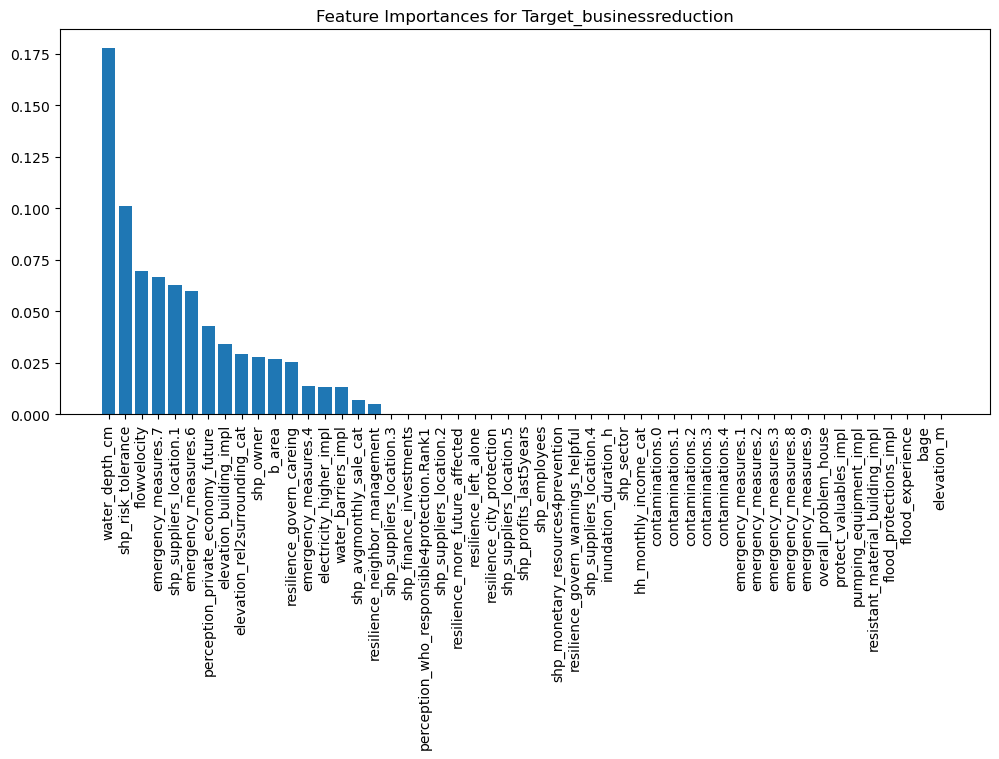

In [380]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))

## coef of feature importances
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : np.absolute(elastic_net_eval.coef_),
     }) 

# drop features which dont reduce the loss
#df_importance = df_importance.loc[df_importance.importances > 0.000, : ] 
df_importance = df_importance.sort_values("importances", ascending=False)

plt.bar(df_importance.name, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [54]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")